In [1]:
# loading libraries
import numpy as np
import matplotlib.pyplot as plt   
import tensorflow as tf
import collections 
import os
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

E:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# loading data
def load_data(file):
    with open(file, 'r') as f:
        texts = f.read()
    return texts
data_dir = 'textsets' 
data_file = 'shakespeare.txt'
file = os.path.join(data_dir, data_file)
data = load_data(file)

In [3]:
data[:200]

"From fairest creatures we desire increase,  That thereby beauty's rose might never die,  But as the riper should by time decease,  His tender heir might bear his memory:  But thou contracted to thine "

In [4]:
# organising texts into a list
text_data = []
text_data.append(data)

In [5]:
# cleaning texts
def clean_texts(text_data):
    texts = [x.lower() for x in text_data]
     # Removing numbers
    digits = '0123456789'
    texts = [''.join(c for c in x if c not in digits) for x in texts]
    # Removing punctuation
    texts = [''.join(c for c in x if c not in string.punctuation)
                 for x in texts]
    # Trimming extra whitespace
    texts = [' '.join(x.split()) for x in texts]
    return texts
texts = clean_texts(text_data) 

In [6]:
# organising words into tokens
def tokeniser(data):
    # turn sentences (list of strings) into lists of words
    split_texts = [s.split() for s in data]
    tokenised_words  = [x for sublist in split_texts for x in sublist] 
    return tokenised_words 
tokens = tokeniser(texts)

In [7]:
# removing most ccommon english words
def stop_words(tokenised):
    stop_words = stopwords.words('english')
    non_stopwords = [c for c in tokenised if c not in stop_words]
    return non_stopwords 
tokens = stop_words(tokens)

In [8]:
# selecting only root words
def lemmatize(tokenised):
    lemmatizer = WordNetLemmatizer()
    lematized = [lemmatizer.lemmatize(x) for x in tokenised]
    return lematized
tokens = lemmatize(tokens)

In [9]:
print(len(tokens))
print(len(set(tokens)))

478914
26113


In [10]:
tokens[1]

'creature'

In [11]:
# organisint corpus into sequences of tokens
seq_len = 50+1
seques = []
for i in range(seq_len, len(tokens)):
    # selsect sequences of tokens
    seq = tokens[i-seq_len:i]
    # convert into a line
    line = ' '.join(c for c in seq)
    # store
    seques.append(line)
print(len(seques))

478863


In [12]:
seques[0]

'fairest creature desire increase thereby beauty rose might never die riper time decease tender heir might bear memory thou contracted thine bright eye feedst thy light flame selfsubstantial fuel making famine abundance lie thy self thy foe thy sweet self cruel thou art world fresh ornament herald gaudy spring within thine'

In [13]:
# selecting first 10000 sequences for training
seqs = seques[:10000]

In [14]:
# generating tokens from sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(seqs)
sequenes = tokenizer.texts_to_sequences(seqs)

Using TensorFlow backend.


In [15]:
print(sequenes[1][1])
print(sequenes[2][0])

156
156


In [16]:
# generating vocabulary size
voc_size = len(tokenizer.word_index) + 1
voc_size

2916

In [17]:
# generating features and labels for training
from keras.utils import to_categorical

sequences = np.array(sequenes)
print(sequences.shape)
inputs, targets = sequences[:,:-1], sequences[:,-1]
# one hot encoding label variables
targets = to_categorical(targets, num_classes=voc_size)

(10000, 51)


In [18]:
inputs.shape

(10000, 50)

In [19]:
seq_len = inputs.shape[1]

In [20]:
# defining model architecture
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

out_dim = 64
n_units = 32
model = Sequential()
model.add(Embedding(voc_size, out_dim, input_length=seq_len))
model.add(LSTM(n_units))
model.add(Dense(n_units, activation='relu'))
model.add(Dense(voc_size, activation='softmax'))   

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            186624    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2916)              96228     
Total params: 296,324
Trainable params: 296,324
Non-trainable params: 0
_________________________________________________________________


In [22]:
# defining model evaluation parameters
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# model training
history = model.fit(inputs, targets, batch_size=64, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 193s 19ms/step - loss: 7.5044 - acc: 0.0250
Epoch 2/10
10000/10000 [==============================] - 141s 14ms/step - loss: 7.0749 - acc: 0.0288
Epoch 3/10
10000/10000 [==============================] - 139s 14ms/step - loss: 6.9700 - acc: 0.0279
Epoch 4/10
10000/10000 [==============================] - 134s 13ms/step - loss: 6.8869 - acc: 0.0293
Epoch 5/10
10000/10000 [==============================] - 184s 18ms/step - loss: 6.8326 - acc: 0.0294
Epoch 6/10
10000/10000 [==============================] - 154s 15ms/step - loss: 6.7786 - acc: 0.0280
Epoch 7/10
10000/10000 [==============================] - 136s 14ms/step - loss: 6.7178 - acc: 0.0290
Epoch 8/10
10000/10000 [==============================] - 141s 14ms/step - loss: 6.6266 - acc: 0.0307
Epoch 9/10
10000/10000 [==============================] - 142s 14ms/step - loss: 6.5506 - acc: 0.0302
Epoch 10/10
10000/10000 [==============================] - 140s 14ms/step - loss: 

In [24]:
# saving learned parameters
model.save('next_words_model_00.h5')

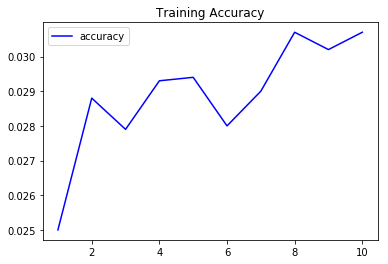

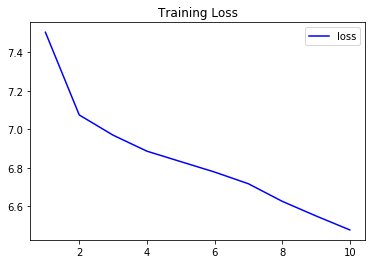

In [25]:
# plotting model performance
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [26]:
# adding extra LSTM cell and drop-outs 
from keras import layers

out_dim = 64
n_units = 32
model = Sequential()
model.add(Embedding(voc_size, out_dim, input_length=seq_len))
model.add(LSTM(n_units, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(n_units))
model.add(layers.Dropout(0.2))
model.add(Dense(n_units, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(voc_size, activation='softmax'))   

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            186624    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# training model over more iterations
history = model.fit(inputs, targets, batch_size=64, epochs=500)

Epoch 1/500
10000/10000 [==============================] - 340s 34ms/step - loss: 7.4949 - acc: 0.0242
Epoch 2/500
10000/10000 [==============================] - 258s 26ms/step - loss: 7.1228 - acc: 0.0274
Epoch 3/500
10000/10000 [==============================] - 243s 24ms/step - loss: 7.0691 - acc: 0.0273
Epoch 4/500
10000/10000 [==============================] - 241s 24ms/step - loss: 7.0076 - acc: 0.0287
Epoch 5/500
10000/10000 [==============================] - 262s 26ms/step - loss: 6.9575 - acc: 0.0281
Epoch 6/500
10000/10000 [==============================] - 238s 24ms/step - loss: 6.9180 - acc: 0.0286
Epoch 7/500
10000/10000 [==============================] - 239s 24ms/step - loss: 6.8642 - acc: 0.0269
Epoch 8/500
10000/10000 [==============================] - 268s 27ms/step - loss: 6.8143 - acc: 0.0282
Epoch 9/500
10000/10000 [==============================] - 265s 27ms/step - loss: 6.7428 - acc: 0.0279
Epoch 10/500
10000/10000 [==============================] - 233s 23ms/ste

10000/10000 [==============================] - 241s 24ms/step - loss: 4.8273 - acc: 0.0632
Epoch 80/500
10000/10000 [==============================] - 241s 24ms/step - loss: 4.8041 - acc: 0.0695
Epoch 81/500
10000/10000 [==============================] - 242s 24ms/step - loss: 4.8055 - acc: 0.0695
Epoch 82/500
10000/10000 [==============================] - 241s 24ms/step - loss: 4.7706 - acc: 0.0703
Epoch 83/500
10000/10000 [==============================] - 239s 24ms/step - loss: 4.7773 - acc: 0.0704
Epoch 84/500
10000/10000 [==============================] - 238s 24ms/step - loss: 4.7521 - acc: 0.0696
Epoch 85/500
10000/10000 [==============================] - 241s 24ms/step - loss: 4.7184 - acc: 0.0742
Epoch 86/500
10000/10000 [==============================] - 247s 25ms/step - loss: 4.7072 - acc: 0.0721
Epoch 87/500
10000/10000 [==============================] - 229s 23ms/step - loss: 4.7008 - acc: 0.0723
Epoch 88/500
10000/10000 [==============================] - 228s 23ms/step - 

10000/10000 [==============================] - 231s 23ms/step - loss: 4.0666 - acc: 0.1174
Epoch 157/500
10000/10000 [==============================] - 230s 23ms/step - loss: 4.0159 - acc: 0.1171
Epoch 158/500
10000/10000 [==============================] - 229s 23ms/step - loss: 4.0247 - acc: 0.1308
Epoch 159/500
10000/10000 [==============================] - 229s 23ms/step - loss: 4.0215 - acc: 0.1240
Epoch 160/500
10000/10000 [==============================] - 232s 23ms/step - loss: 4.0273 - acc: 0.1220
Epoch 161/500
10000/10000 [==============================] - 231s 23ms/step - loss: 3.9874 - acc: 0.1235
Epoch 162/500
10000/10000 [==============================] - 231s 23ms/step - loss: 4.0002 - acc: 0.1289
Epoch 163/500
10000/10000 [==============================] - 229s 23ms/step - loss: 3.9737 - acc: 0.1290
Epoch 164/500
10000/10000 [==============================] - 232s 23ms/step - loss: 3.9769 - acc: 0.1276
Epoch 165/500
10000/10000 [==============================] - 231s 23m

10000/10000 [==============================] - 235s 23ms/step - loss: 3.5510 - acc: 0.1775
Epoch 235/500
10000/10000 [==============================] - 487s 49ms/step - loss: 3.5604 - acc: 0.1721
Epoch 236/500
10000/10000 [==============================] - 240s 24ms/step - loss: 3.5466 - acc: 0.1776
Epoch 237/500
10000/10000 [==============================] - 237s 24ms/step - loss: 3.5435 - acc: 0.1755
Epoch 238/500
10000/10000 [==============================] - 269s 27ms/step - loss: 3.5386 - acc: 0.1778
Epoch 239/500
10000/10000 [==============================] - 244s 24ms/step - loss: 3.5418 - acc: 0.1788
Epoch 240/500
10000/10000 [==============================] - 231s 23ms/step - loss: 3.5245 - acc: 0.1725
Epoch 241/500
10000/10000 [==============================] - 233s 23ms/step - loss: 3.5280 - acc: 0.1839
Epoch 242/500
10000/10000 [==============================] - 233s 23ms/step - loss: 3.5458 - acc: 0.1743
Epoch 243/500
10000/10000 [==============================] - 238s 24m

10000/10000 [==============================] - 229s 23ms/step - loss: 3.2114 - acc: 0.2266
Epoch 313/500
10000/10000 [==============================] - 228s 23ms/step - loss: 3.2064 - acc: 0.2293
Epoch 314/500
10000/10000 [==============================] - 224s 22ms/step - loss: 3.1952 - acc: 0.2376
Epoch 315/500
10000/10000 [==============================] - 221s 22ms/step - loss: 3.2048 - acc: 0.2291
Epoch 316/500
10000/10000 [==============================] - 8293s 829ms/step - loss: 3.1710 - acc: 0.2328
Epoch 317/500
10000/10000 [==============================] - 2216s 222ms/step - loss: 3.1972 - acc: 0.2306
Epoch 318/500
10000/10000 [==============================] - 252s 25ms/step - loss: 3.1793 - acc: 0.2327
Epoch 319/500
10000/10000 [==============================] - 240s 24ms/step - loss: 3.1885 - acc: 0.2366
Epoch 320/500
10000/10000 [==============================] - 255s 25ms/step - loss: 3.1755 - acc: 0.2382
Epoch 321/500
10000/10000 [==============================] - 234s

10000/10000 [==============================] - 229s 23ms/step - loss: 2.9667 - acc: 0.2706
Epoch 391/500
10000/10000 [==============================] - 232s 23ms/step - loss: 2.9373 - acc: 0.2797
Epoch 392/500
10000/10000 [==============================] - 229s 23ms/step - loss: 2.9439 - acc: 0.2753
Epoch 393/500
10000/10000 [==============================] - 223s 22ms/step - loss: 2.9734 - acc: 0.2789
Epoch 394/500
10000/10000 [==============================] - 223s 22ms/step - loss: 2.9346 - acc: 0.2824
Epoch 395/500
10000/10000 [==============================] - 18132s 2s/step - loss: 2.9671 - acc: 0.2763
Epoch 396/500
10000/10000 [==============================] - 244s 24ms/step - loss: 2.9140 - acc: 0.2809
Epoch 397/500
10000/10000 [==============================] - 237s 24ms/step - loss: 2.9331 - acc: 0.2773
Epoch 398/500
10000/10000 [==============================] - 243s 24ms/step - loss: 2.9134 - acc: 0.2784
Epoch 399/500
10000/10000 [==============================] - 240s 24m

10000/10000 [==============================] - 230s 23ms/step - loss: 2.7230 - acc: 0.3204
Epoch 469/500
10000/10000 [==============================] - 229s 23ms/step - loss: 2.7430 - acc: 0.3249
Epoch 470/500
10000/10000 [==============================] - 230s 23ms/step - loss: 2.7237 - acc: 0.3204
Epoch 471/500
10000/10000 [==============================] - 224s 22ms/step - loss: 2.7167 - acc: 0.3186
Epoch 472/500
10000/10000 [==============================] - 224s 22ms/step - loss: 2.6945 - acc: 0.3315
Epoch 473/500
10000/10000 [==============================] - 223s 22ms/step - loss: 2.7224 - acc: 0.3186
Epoch 474/500
10000/10000 [==============================] - 223s 22ms/step - loss: 2.6994 - acc: 0.3224
Epoch 475/500
10000/10000 [==============================] - 1013s 101ms/step - loss: 2.7011 - acc: 0.3248
Epoch 476/500
10000/10000 [==============================] - 240s 24ms/step - loss: 2.7124 - acc: 0.3185
Epoch 477/500
10000/10000 [==============================] - 247s 2

In [30]:
model.save('next_words_model_01.h5')

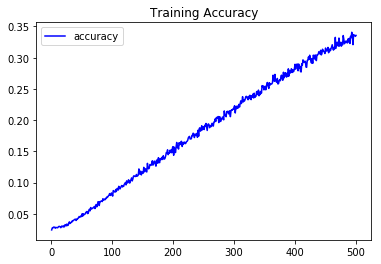

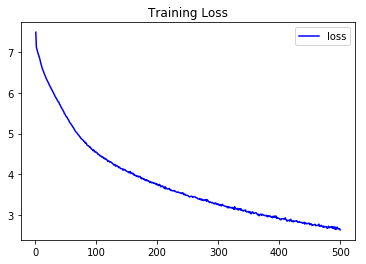

In [31]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [32]:
from pickle import dump
dump(tokenizer, open('tokenizer.pkl','wb'))

In [33]:
len(seqs)

10000

In [34]:
seq_length = len(seqs[0].split()) - 1

model = load_model('language_1.h5')

In [35]:
seq_length

50

In [36]:
from pickle import load
tokeniser = load(open('tokenizer.pkl','rb'))

In [37]:
import random
seed_text = seqs[random.randint(0,len(seqs))]

In [38]:
print(seed_text + '\n')

restful death cry behold desert beggar born needy nothing trimmed jollity purest faith unhappily forsworn gilded honour shamefully misplaced maiden virtue rudely strumpeted right perfection wrongfully disgraced strength limping sway disabled art made tonguetied authority folly doctorlike controlling skill simple truth miscalled simplicity captive good attending captain ill tired would gone



In [39]:
from keras.preprocessing.sequence import pad_sequences

def generate_sequence(model, tokeniser, seq_length, seed_text, n_words):
    result = []
    in_text = seed_text
    print (in_text)
    for _ in range(n_words):
        encoded = tokeniser.texts_to_sequences([in_text])[0]
        encoded = encoded#[1:]
        #encoded_text = np.array(encoded)
        #encoded_text = encoded_text.reshape(1,-1)
        #rint(encoded_text.shape)
        encoded_text = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        pred = model.predict_classes(encoded_text, verbose=0)
        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == pred:
                predicted_word = word
                break
        in_text += ' ' + predicted_word
        result.append(predicted_word)
    return ' '.join(result)

In [40]:
n_words = 50
generated_sequence = generate_sequence(model, tokeniser, seq_length, seed_text, n_words)

restful death cry behold desert beggar born needy nothing trimmed jollity purest faith unhappily forsworn gilded honour shamefully misplaced maiden virtue rudely strumpeted right perfection wrongfully disgraced strength limping sway disabled art made tonguetied authority folly doctorlike controlling skill simple truth miscalled simplicity captive good attending captain ill tired would gone


In [41]:
print(generated_sequence)

save youth fool thy alone youth time fair four two alone sink death oppressed melancholy life composition recured swift messenger returned thee even like engraft new uphold stormy wretch man doth teeming lovegod captain man mortality bertram countess time helena majesty passage divert sight hath count countess time good paris
